In [1]:
import pickle
from matplotlib.gridspec import GridSpecFromSubplotSpec
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import seaborn as sns
import aptwrapper
import xarray as xr

In [2]:
CONDITION_ORDER = ['buffer', 'H₂O₂', 'NiCl₂', 'CoCl₂', 'heat', 'p53', 'p2','p33']

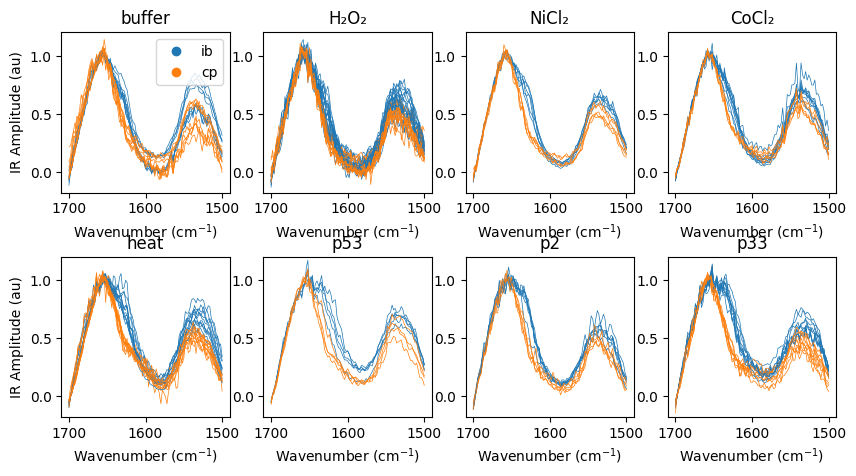

In [3]:
spectra_processed = pickle.load(open('./cache/spectra_veven_processed.pkl', 'rb'))
spectra_processed = spectra_processed.isel(si=spectra_processed.experiment == "chemical_stress_screen")
spectra_raw = pickle.load(open('./cache/spectra_veven_raw.pkl', 'rb'))
spectra_raw = spectra_raw.isel(si=spectra_raw.experiment == "chemical_stress_screen")

spectrum_quantification = pickle.load(open('./cache/spectrum_quantification.pkl', 'rb')).query(
    'experiment == "chemical_stress_screen" and feature != "bg"'
)
def split_ax(parent_ax, rows, cols, squeeze=True, **kwargs):
    # parent_ax.set_visible(False)
    parent_ax.set_frame_on(False)
    parent_ax.set(xticks=[], yticks=[])
    gs = GridSpecFromSubplotSpec(rows, cols, subplot_spec=parent_ax, **kwargs)
    axs = np.array([[plt.subplot(gs[i,j]) for j in range(cols)] for i in range(rows)])
    if squeeze: axs = axs.squeeze()
    return axs

def show_spectra(parent_ax=None):

    if parent_ax is None: 
        parent_ax = plt.gca()

    # Generate subplots
    num_conditions = 8
    ax = split_ax(parent_ax, 2, num_conditions//2, hspace=.4)
    
    # Loop through conditions
    for i, c in enumerate(CONDITION_ORDER):
        
        # Get subset of spectra in this condition
        ss = spectra_processed.sel(
            si=(spectra_processed.condition==c)&(spectra_processed.feature!='bg'), 
            v=slice(1500, 1700)
        )['IR Amplitude (mV)']
        # ss = aptwrapper.savgol(ss, 17, 3)

        # Plot with the right color
        for sj in ss:
            color = 'C0' if sj.feature=='ib' else 'C1'
            ax[i//4, i%4].plot(sj.v, sj, c=color, lw=.5)
        
        # Subplot properties
        ax[i//4, i%4].invert_xaxis()
        ax[i//4, i%4].set_title(c)
        ax[i//4, i%4].set_xlabel('Wavenumber (cm$^{-1}$)')
        if i%4==0: ax[i//4, i%4].set_ylabel('IR Amplitude (au)')
        # else: ax[i//4, i%4].set_yticklabels([])
        ax[i//4, i%4].set_ylim(ax[0,0].get_ylim())

    ax[0,0].legend(
        loc='upper right',
        handles=[
            Line2D([0], [0], color='C0', lw=0, marker='o', label='ib'),
            Line2D([0], [0], color='C1', lw=0, marker='o', label='cp'),
    ])
    for a in ax.ravel():
        a.yaxis.set_major_locator(plt.MaxNLocator(3))

plt.figure(figsize=(10,5))
show_spectra()

## Quantification

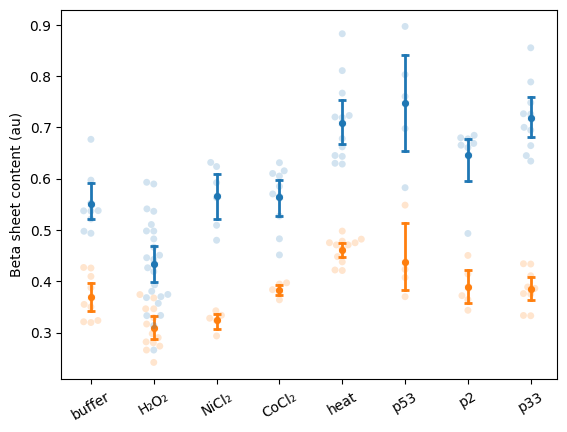

In [4]:
def plot_beta_content(ax=None):
    if ax is None: ax = plt.gca()

    df = (
        spectrum_quantification
        # .groupby('dataset_id')
        # .apply(
        #     lambda x: x.assign(
        #         beta = x['beta'] / x.query('feature=="cp"')['beta'].mean(),
        # ))
    )
    
    sns.swarmplot(
        df, x='condition', y='beta', hue='feature', ax=ax, 
        order=CONDITION_ORDER, alpha=.2, legend=False,
        # hue_order=CONDITION_ORDER, palette=colormap.values(),
    )
    sns.lineplot(
        df, x='condition', y='beta', hue='feature', ax=ax, 
        lw=0, err_style='bars', err_kws=dict(lw=2, capsize=3, capthick=2), legend=False, marker='o',
        # errorbar=('ci', 95)
        # hue_order=CONDITION_ORDER, palette=colormap.values(),
    )
    ax.set_xlabel('')
    ax.set_ylabel('Beta sheet content (au)')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)  # Provide the labels argument
    # sns.move_legend(ax, 'upper left')

plot_beta_content()

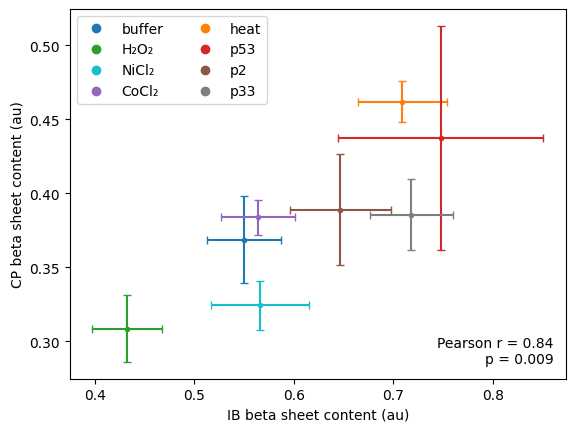

In [5]:
from scipy.stats import pearsonr

crest = sns.color_palette('crest', 5)
flare = sns.color_palette('flare', 5)

colormap = {
    'buffer': flare[0],
    'H₂O₂':   flare[1],
    'NiCl₂':  flare[2],
    'CoCl₂':  flare[3],
    'heat':   crest[0],
    'p53':    crest[1],
    'p2':     crest[2],
    'p33':    crest[3],
}

colormap = {
    'buffer': sns.color_palette()[0],
    'H₂O₂':   sns.color_palette()[2],
    'NiCl₂':  sns.color_palette()[9],
    'CoCl₂':  sns.color_palette()[4],
    'heat':   sns.color_palette()[1],
    'p53':    sns.color_palette()[3],
    'p2':     sns.color_palette()[5],
    'p33':    sns.color_palette()[7],
}

def plot_beta_content_correlated(ax=None):
    if ax is None: ax = plt.gca()

    df = spectrum_quantification
    means = df.groupby(['feature', 'condition']).beta.mean()
    sem = df.groupby(['feature', 'condition']).beta.sem()
    ses = 1.96 * sem 

    for c in CONDITION_ORDER:
        ax.errorbar(
            x=means['ib'][c], xerr=ses['ib'][c],
            y=means['cp'][c], yerr=ses['cp'][c],
            fmt='.', capsize=3, label=c, color=colormap[c]
        )
    ax.legend(loc='upper left', ncols=2, handles=[
        Line2D([0], [0], color=color, lw=0, marker='o', label=name)
        for name, color in colormap.items()
    ])
    ax.set_xlabel('IB beta sheet content (au)')
    ax.set_ylabel('CP beta sheet content (au)')

    p = pearsonr(means['ib'], means['cp'])
    aptwrapper.annotate(
        ax, f'Pearson r = {p[0]:.2f}\np = {p[1]:.3f}', 
        loc='lower right', c='k', weight='normal', ha='right')

plot_beta_content_correlated()

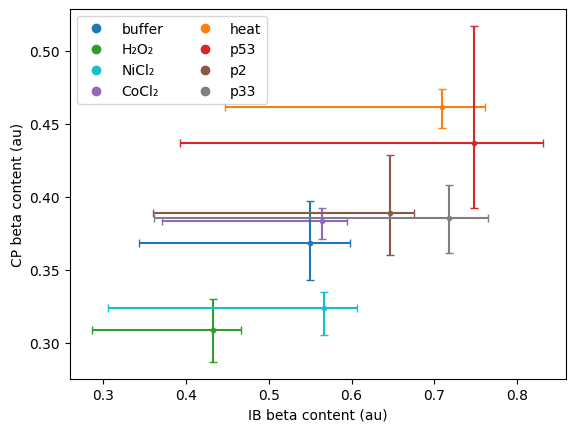

In [6]:
import scipy.stats

def plot_beta_content_correlated2(ax=None):
    if ax is None: ax = plt.gca()

    for i, g in spectrum_quantification.groupby('condition'):
        dfcp = g.query('feature=="cp"').beta
        dfib = g.query('feature=="ib"').beta
        bcp = scipy.stats.bootstrap((dfcp,), np.mean).confidence_interval
        bib = scipy.stats.bootstrap((dfib,), np.mean).confidence_interval

        ax.errorbar(
            x=dfib.mean(), xerr=([dfib.mean() - bcp.low], [bib.high - dfib.mean()]),
            y=dfcp.mean(), yerr=([dfcp.mean() - bcp.low], [bcp.high - dfcp.mean()]),
            c=colormap[i],
            fmt='.', capsize=3
        )

    ax.legend(loc='upper left', ncols=2, handles=[
        Line2D([0], [0], color=color, lw=0, marker='o', label=name)
        for name, color in colormap.items()
    ])
    ax.set_xlabel('IB beta content (au)')
    ax.set_ylabel('CP beta content (au)')

plot_beta_content_correlated2()

## 2nd derivative

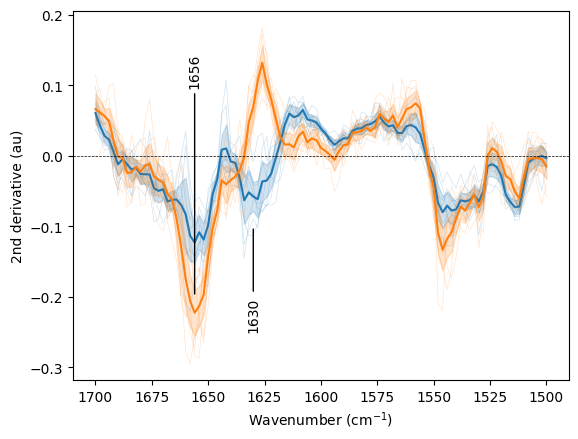

In [7]:
def annotate_peak(ax, x, y, text=None, offset=-40, ha='center', va=None):
    if text is None: text=x
    if va is None and offset>0: va='baseline'
    if va is None and offset<0: va='top'
    # y = ymax if offset > 0 else ymin
    ax.annotate(
        text,
        [x,y],
        [x,
        y+offset],
        textcoords='data',
        rotation='vertical',
        va=va,
        ha=ha,
        arrowprops=dict(arrowstyle='-'),
        # fontsize=8
    )

def plot_2diff(ax=None):
    if ax is None: ax = plt.gca()

    for i, f in enumerate(['ib', 'cp']):
        s2 = (
            spectra_processed['IR Amplitude (mV)']
            .sel(si=spectra_processed.feature==f)
            .groupby('condition').mean('si')
            .pipe(aptwrapper.savgol, 10,2,2)
            .pipe(lambda x: x / np.abs(x.sel(v=slice(1600,1700)).sum('v')))
            .sel(v=slice(1500, 1700))
        )

        m = s2.mean('condition')
        se = 1.96 * s2.std('condition') / np.sqrt(s2.count('condition'))
        ax.plot(s2.v, m, c=f'C{i}', label=f)
        ax.fill_between(s2.v, m+se, m-se, color=f'C{i}', alpha=.2)

        for s in s2:
            ax.plot(s.v, s, c=f'C{i}', lw=.5, alpha=.2)

    # ax.legend()
    ax.invert_xaxis()
    ax.axhline(0, c='k', lw=.5, ls='--')
    ax.set_ylabel('2nd derivative (au)')

    ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    annotate_peak(ax, 1656, -.2, offset=.3)
    annotate_peak(ax, 1630, -.1, offset=-.1)

plot_2diff()

## PCA

In [8]:
def transform_darray(fn, data, **new_coords):
    return xr.DataArray(fn(data), dims=['si', *new_coords.keys()], coords=dict(
        **new_coords,
        **{k:v for k, v in data.coords.items() if k != 'v'},
    ))

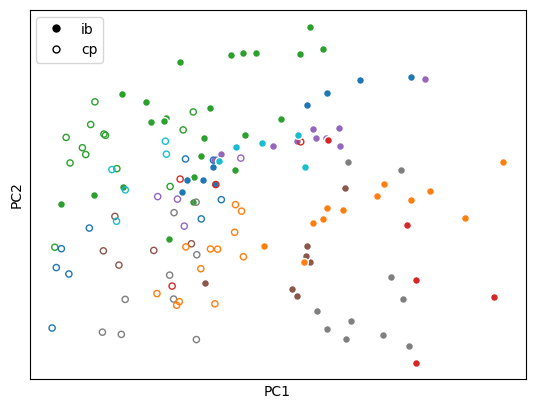

In [9]:
from sklearn.decomposition import PCA
def get_pca(spectra):
    pca_dims = 10
    kernel = PCA(n_components=pca_dims)
    kernel.fit(spectra)
    pca = transform_darray(kernel.transform, spectra, pc=np.arange(1,pca_dims+1))
    pca_df = pca.to_dataframe('val').reset_index().pivot(index='si', columns='pc')
    loadings = kernel.inverse_transform(np.eye(pca_dims))
    return kernel, pca_df, loadings

def plot_pca_scatter(ax=None, legend=True):
    if ax is None: ax = plt.gca()

    # Load data
    input = spectra_processed.sel(
        si=spectra_processed.feature != 'bg',
        v=slice(1500,1680)
    )['IR Amplitude (mV)']

    kernel, pca_df, loadings = get_pca(input)
    for i, r in pca_df.iterrows():
        x = r.val[1]
        y = r.val[2]
        feature = r.feature[1]
        condition = r.condition[1]
        if feature == 'ib': style = {'facecolor': colormap[condition], 'edgecolor': 'w', 's': 32}
        else: style = {'facecolor': 'none', 'edgecolor': colormap[condition], 's':20}
        ax.scatter(x, y, marker='o', **style)
    
    ax.set(xlabel='PC1', ylabel='PC2', xticks=[], yticks=[])
    if legend:
        ax.legend(title=False, loc='upper left', handles=[
            Line2D([0], [0], color='k', markeredgecolor='w', lw=0, marker='o', label='ib', ms=7),
            Line2D([0], [0], color='w', markeredgecolor='k', lw=0, marker='o', label='cp', ms=5)   
        ])

    else: ax.legend().remove()

plot_pca_scatter()

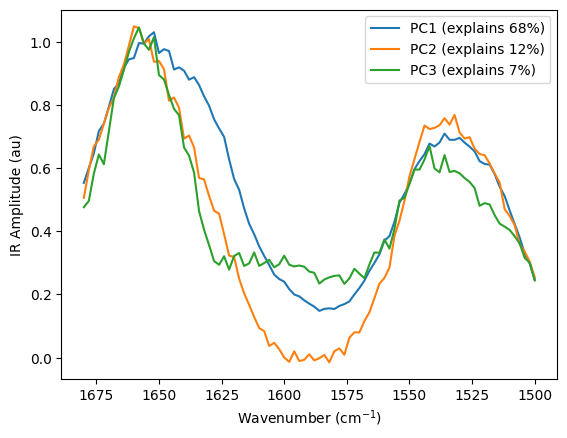

In [10]:
def plot_pca_loadings(ax=None):
    if ax is None: ax = plt.gca()

    # Load data
    spectra = spectra_processed['IR Amplitude (mV)']
    spectra = spectra.sel(
        si=spectra.feature != 'bg',
        v=slice(1500,1680)
    )

    kernel, pca_df, loadings = get_pca(spectra)
    for i in range(3):
        ax.plot(spectra.v, loadings.T[:,i], label=f'PC{i+1} (explains {100*kernel.explained_variance_ratio_[i]:.0f}%)')

    ax.legend()
    ax.invert_xaxis()
    ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax.set_ylabel('IR Amplitude (au)')
plot_pca_loadings()

## UMAP

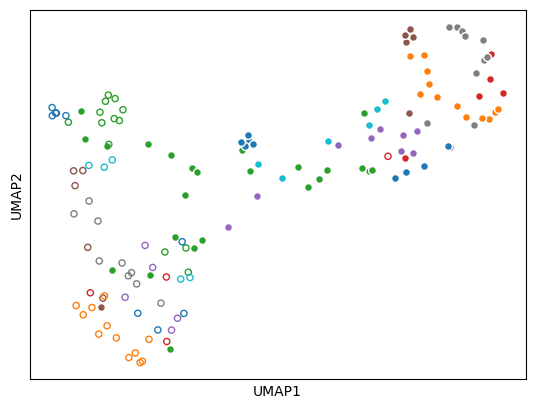

In [11]:
from umap import UMAP
def plot_umap(ax=None):
    if ax is None: ax = plt.gca()

    # Load data
    spectra = spectra_processed['IR Amplitude (mV)']
    spectra = spectra.sel(
        si=spectra.feature!='bg',
        v=slice(1500,1680)
    )
    
    # Get UMAP embedding
    umap = UMAP(
        min_dist=.1, init='spectral', n_epochs=1000, n_neighbors=20,
        n_components=2, random_state=14, n_jobs=1)
    embedding = transform_darray(
        umap.fit_transform,
        spectra,
        umap=[0,1],
    )
    
    # Plot
    df = embedding.to_dataframe('val').unstack()
    for i, r in df.iterrows():
        x = -r.val[0]
        y = r.val[1]
        feature = r.feature[1]
        condition = r.condition[1]
        if feature == 'ib': style = {'facecolor': colormap[condition], 'edgecolor': 'w', 's': 32}
        else: style = {'facecolor': 'none', 'edgecolor': colormap[condition], 's':20}
        ax.scatter(x, y, marker='o', **style)

    # sns.scatterplot(
    #     x=-df.val[0], y=df.val[1], hue=df.condition[0], style=df.feature[0], 
    #     hue_order=CONDITION_ORDER, palette=colormap.values(), legend=False,
    #     ax=ax)
    ax.set(xlabel='UMAP1', ylabel='UMAP2', xticks=[], yticks=[])
    # return df

plot_umap()

# Stress strength

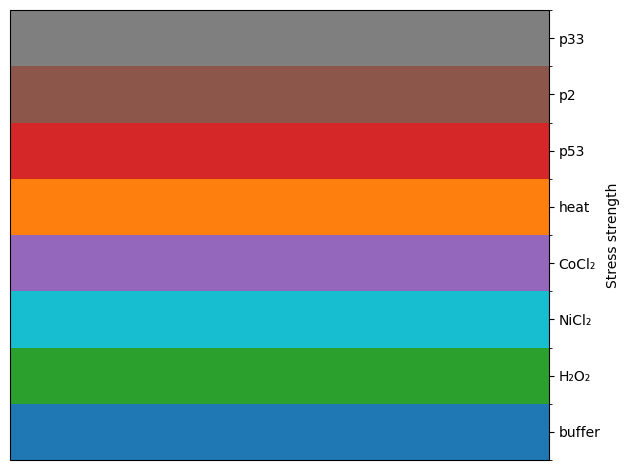

In [12]:
import matplotlib.colors
import matplotlib.cm

def fake_cbar(ax=None):
    if ax is None: fig, ax = plt.subplots(layout='tight')

    cmap = matplotlib.colors.ListedColormap(
        colormap.values()
    )
    bounds = range(9)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    ax.figure.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax, orientation='vertical',
                label="Stress strength")
    ax.set_yticks(np.arange(8)+0.5, colormap.keys())

fake_cbar()

# Composite

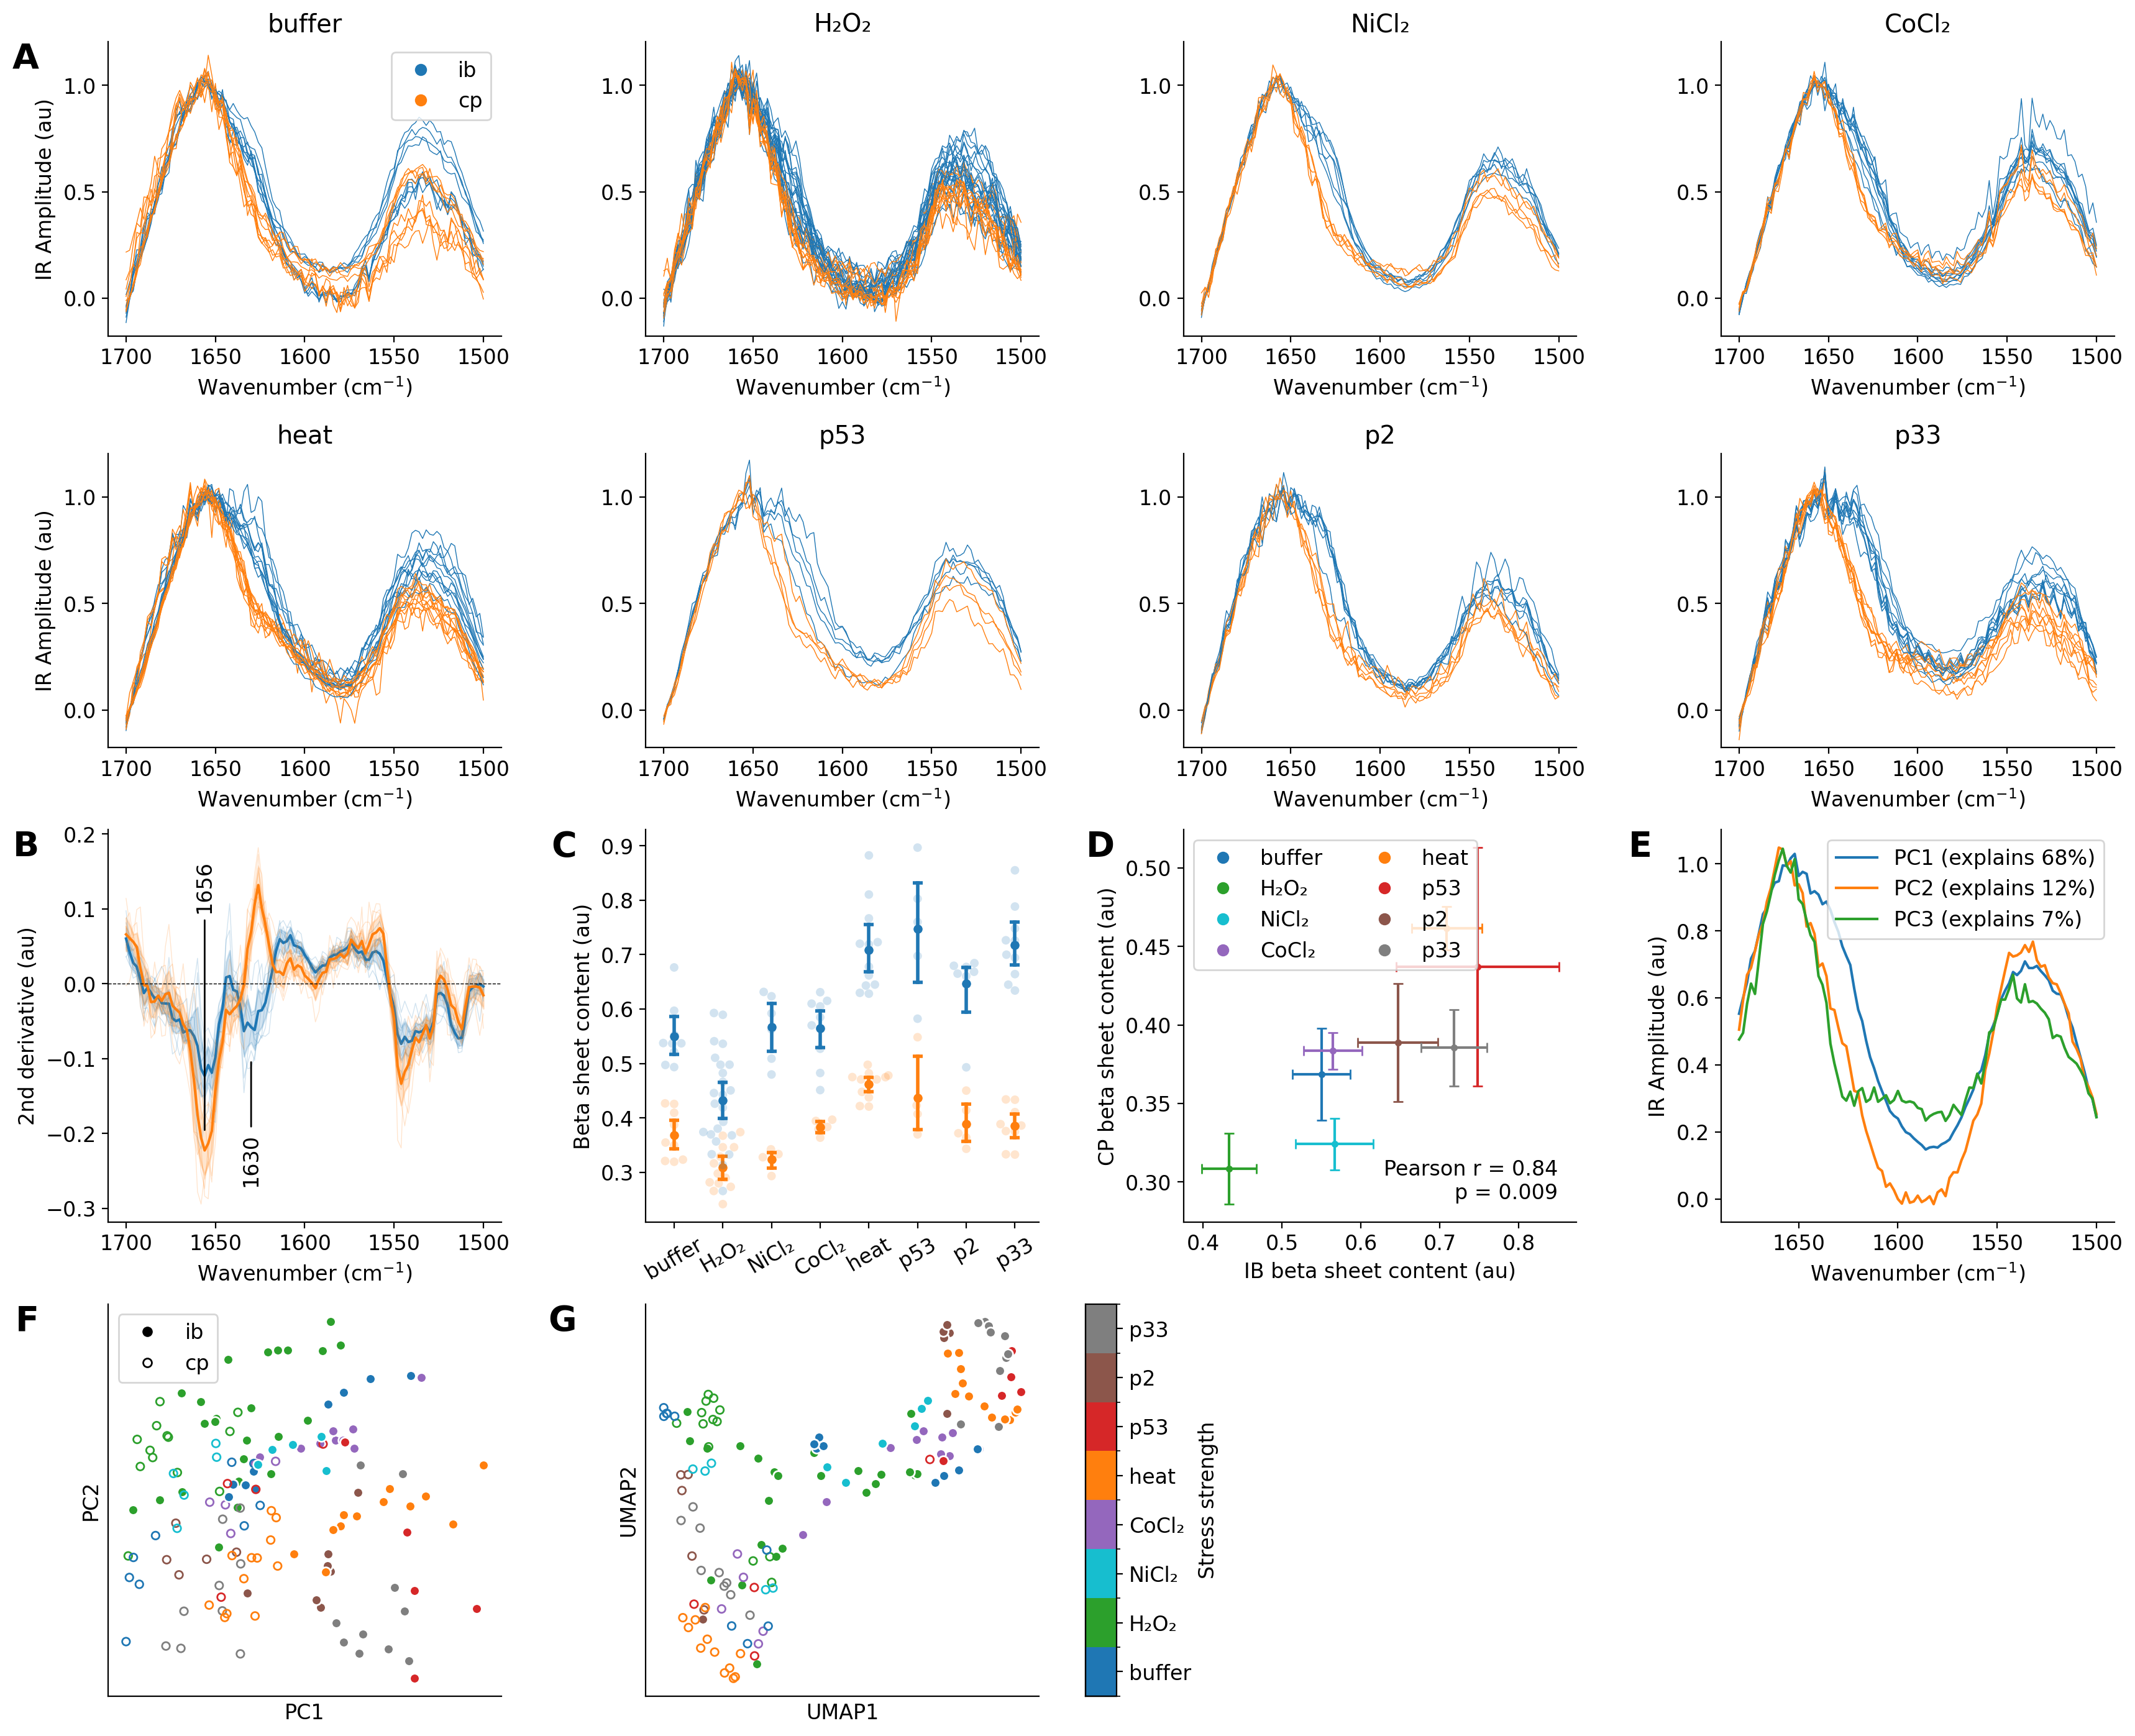

In [13]:
with plt.rc_context({
    'figure.figsize': (17,14),
    'figure.dpi': 200,
    'font.size': 12,
    'savefig.bbox': 'tight',
    'legend.loc': 'upper right',
}):
    
    fig, ax = plt.subplot_mosaic(
        gridspec_kw={'height_ratios':[1.8,1,1]},
        mosaic=[
            ['a', 'a', 'a', 'a'],
            ['b', 'c', 'd', 'e'],
            ['f', 'g', 'h', 'i']
    ])
    plt.tight_layout(h_pad=2, w_pad=4)

    show_spectra(ax['a'])
    plot_2diff(ax['b'])
    plot_beta_content(ax['c'])
    plot_beta_content_correlated(ax['d'])
    plot_pca_loadings(ax['e'])
    plot_pca_scatter(ax['f'])
    plot_umap(ax['g'])

    kwargs = dict(ha='right', va='top', xycoords=('axes points', 'axes fraction'), fontsize=20, fontweight='bold')
    xy = (-40, 1)
    ax['a'].annotate('A', xy, **kwargs)
    ax['b'].annotate('B', xy, **kwargs)
    ax['c'].annotate('C', xy, **kwargs)
    ax['d'].annotate('D', xy, **kwargs)
    ax['e'].annotate('E', xy, **kwargs)
    ax['f'].annotate('F', xy, **kwargs)
    ax['g'].annotate('G', xy, **kwargs)
    ax['h'].axis('off')
    ax['i'].axis('off')

    bbox_ax = ax['h'].get_position()
    # bbox_ax_fig = bbox_ax.transformed(fig.transFigure.inverted())
    cax = fig.add_axes([
        bbox_ax.x0 - (bbox_ax.x1-bbox_ax.x0)*.25,
        bbox_ax.y0,
        (bbox_ax.x1-bbox_ax.x0)*.08,
        bbox_ax.y1-bbox_ax.y0]
    )
    fake_cbar(cax)

    sns.despine()
    # fig.align_ylabels()

    import os
    output_directory = "../figures"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    fig.savefig('../figures/figure_3.pdf', bbox_inches='tight')